In [104]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

In [105]:
Morse = {
    # codes from https://www.itu.int/rec/R-REC-M.1677-1-200910-I/en
    "A": "10111",
    "B": "111010101",
    "C": "11101011101",
    "D": "1110101",
    "E": "1",
    "F": "101011101",
    "G": "111011101",
    "H": "1010101",
    "I": "101",
    "J": "1011101110111",
    "K": "111010111",
    "L": "101110101",
    "M": "1110111",
    "N": "11101",
    "O": "11101110111",
    "P": "10111011101",
    "Q": "1110111010111",
    "R": "1011101",
    "S": "10101",
    "T": "111",
    "U": "1010111",
    "V": "101010111",
    "W": "101110111",
    "X": "11101010111",
    "Y": "1110101110111",
    "Z": "11101110101",
    " ": "0",  # space
    "1": "10111011101110111",
    "2": "101011101110111",
    "3": "1010101110111",
    "4": "10101010111",
    "5": "101010101",
    "6": "11101010101",
    "7": "1110111010101",
    "8": "111011101110101",
    "9": "11101110111011101",
    "0": "1110111011101110111",
    ".": "10111010111010111",  # period
    ",": "1110111010101110111",  # comma
    ":": "11101110111010101",  # colon
    "?": "101011101110101",  # question
    "'": "1011101110111011101",  # apostrophe
    "-": "111010101010111",  # dash or minus
    "/": "1110101011101",  # slash
    "(": "111010111011101",  # left parenthesis
    ")": "1110101110111010111",  # right parenthesis
    "\"": "101110101011101",  # quote
    "=": "1110101010111",  # equals
    "+": "1011101011101",  # plus
    "@": "10111011101011101",  # at sign (@)
    # these punctuation marks are not included in the ITU recommendation,
    # but are found in https://en.wikipedia.org/wiki/Morse_code
    "!": "1110101110101110111",  # exclamation point
    "&": "10111010101",  # ampersand (also prosign for 'WAIT')
    ";": "11101011101011101",  # semicolon
    "_": "10101110111010111",  # underscore
    "$": "10101011101010111"  # dollar sign
}


In [106]:
#take user input
msg = input("Type phrase to translate here: ")
print('\n', msg)
#convert to all uppercase
msg = msg.upper()
#transform from string to an array with each character a separate element
msg = list(msg)
print('\n', msg)
my_morse = []
#evaluate each character in the list and convert to morse
for i in msg:
    my_morse.append(Morse.get(i))

print('\n', my_morse, '\n')


 A

 ['A']

 ['10111'] 



In [107]:
temp_inputs = []
for i in range(len(my_morse)):
    temp_inputs.append(list(my_morse[i]))
print('\n', temp_inputs)

row, col = np.shape(temp_inputs)



 [['1', '0', '1', '1', '1']]


In [108]:
model = nengo.Network(label="Mercier Final Project")

with model:

    #input_node = nengo.Node(Piecewise({0:1, 1:0, 2:1, 3:1, 4:1, 5:0}))

    inputs = []
    for i in range(row):
        inputs.append(nengo.Node(temp_inputs[i]))
    #end with a 0 to indicate end of character
    #inputs.append(nengo.Node(0))

    neurons = []
    for i in range(len(inputs)):
        neurons.append(nengo.networks.EnsembleArray(n_neurons=200, n_ensembles = len(inputs[i])))
    


In [109]:
with model:    
    probes = []
    for i in range(row):
        nengo.Connection(inputs[i], neurons[i].input)
        probe_col = nengo.Probe(neurons[i].output, sample_every=.01, synapse=.001)
        probes.append(probe_col)
        probe_col = []


In [110]:
sim_time = 6
with nengo.Simulator(model) as sim:
    # run for 3 seconds
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Neuron Inputs')

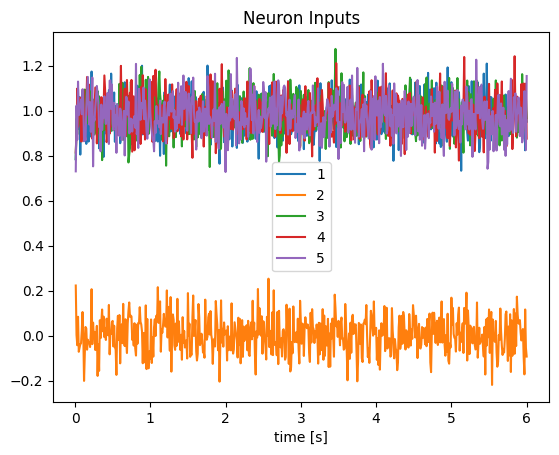

In [111]:
plt.figure()
for i in range(len(probes)):
    plt.plot(sim.trange(sample_every=0.01), sim.data[probes[i]])
plt.xlabel("time [s]")
plt.legend([1, 2, 3, 4, 5])
plt.title("Neuron Inputs")